In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive
%cd MyDrive
%cd vesuvius-from-scratch
!pwd

/content/gdrive
/content/gdrive/MyDrive
/content/gdrive/MyDrive/vesuvius-from-scratch
/content/gdrive/MyDrive/vesuvius-from-scratch


In [24]:
!pwd
!pip install timesformer_pytorch
!pip install segmentation_models_pytorch

/content/gdrive/MyDrive/vesuvius-from-scratch
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=a6e8a51ec33dcdfcaee3431d1991202fca91210c8fac9848730d73df54fb546a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=44596e82e0fc08a904126f09f9c7fcef2713f563c734c27731edf33ad57e8207
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


True
1


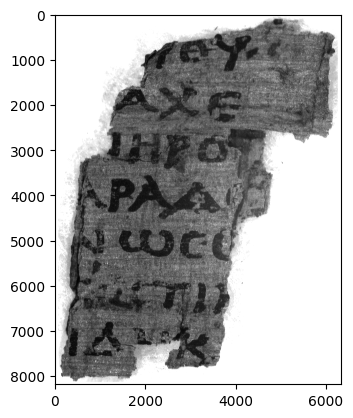

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import segmentation_models_pytorch as smp
from tqdm import tqdm
from ipywidgets import interact, fixed
from timesformer_pytorch import TimeSformer
from torch.optim import AdamW

PREFIX = 'vesuvius-challenge-ink-detection/train/1/'
BUFFER = 31  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 20   # Number of slices in the z direction
TRAINING_STEPS = 30000
LEARNING_RATE = 6e-5
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())
print(torch.cuda.device_count())

# Viz
plt.imshow(Image.open(PREFIX+"ir.png"), cmap="gray")

Let's load these binary images:

 - __mask.png__: a mask of which pixels contain data, and which pixels we should ignore.
 - __inklabels.png__: our label data: whether a pixel contains ink or no ink (which has been hand-labeled based on the infrared photo).

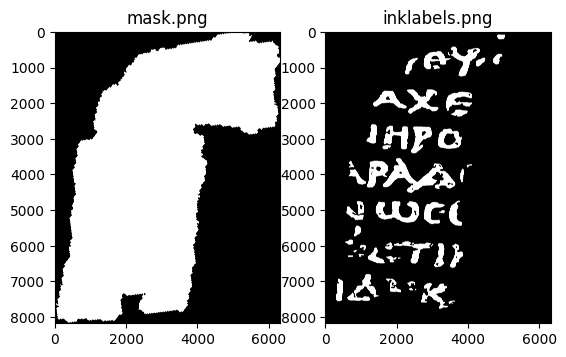

In [28]:
mask = np.array(Image.open(PREFIX+"mask.png").convert('1')) # .convert('1') converts to black&white
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE) # .gt(0) converts to binary mask

# Viz
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(label.cpu(), cmap='gray')

Next, we'll load the 3d x-ray of the fragment. This is represented as a .tif image stack. The image stack is an array of 16-bit grayscale images. Each image represents a "slice" in the z-direction, going from below the papyrus, to above the papyrus. We'll convert it to a 4D tensor of 32-bit floats. We'll also convert the pixel values to the range [0, 1].

To save memory, we'll only load the innermost slices (Z_DIM of them). Let's look at them when we're done.

100%|██████████| 20/20 [00:33<00:00,  1.65s/it]


torch.Size([20, 8181, 6330])


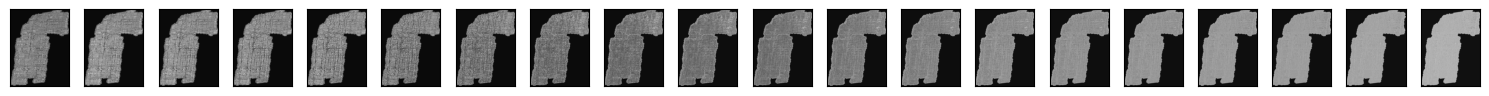

In [29]:
# Load the 3d x-ray scan, one slice at a time
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)
print(image_stack.shape)

# Viz
fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for image, ax in zip(images, axes):
  ax.imshow(np.array(Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
  ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

Can you see the ink in these slices of the 3d x-ray scan..? Neither can we.

Now we'll create a dataset of subvolumes. We use a small rectangle around the letter "P" for our evaluation, and we'll exclude those pixels from the training set. (It's actually a Greek letter "rho", which looks similar to our "P".)

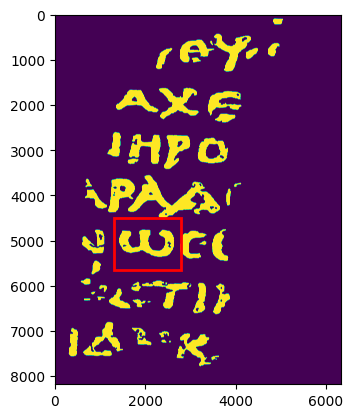

In [30]:
# rect = (1100, 3500, 700, 950)
rect = (1300, 4500, 1500, 1150)

# Viz
fig, ax = plt.subplots()
ax.imshow(label.cpu())
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

Now we'll define a PyTorch dataset and (super simple) model.

In [31]:
# Pytorch needs these custom dataset classes for the model with len and getitem defined
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    # Return data and label at given index
    def __getitem__(self, index):
        y, x = self.pixels[index]
        # subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+2, x-BUFFER:x+BUFFER+2].view(Z_DIM, 1, BUFFER*2+2, BUFFER*2+2) # for timesformer
        try:
            subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+2, x-BUFFER:x+BUFFER+2].view(Z_DIM, 1, BUFFER*2+2, BUFFER*2+2) # for sequential
        except:
            print(self.image_stack[:, y-BUFFER:y+BUFFER+2, x-BUFFER:x+BUFFER+2].shape)
            print('x: ',x,' y: ',y)
            y,x = 4000,4000
            subvolume= self.image_stack[:, y-BUFFER:y+BUFFER+2, x-BUFFER:x+BUFFER+2].view(Z_DIM,1, BUFFER*2+2, BUFFER*2+2)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel

# model = nn.Sequential(
#     nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
#     nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
#     nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
#     nn.Flatten(start_dim=1),
#     nn.LazyLinear(128), nn.ReLU(),
#     nn.LazyLinear(1), nn.Sigmoid()
# ).to(DEVICE)

class CustomTimeSformer(TimeSformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Print shape of input tensor
        # print("Shape of input tensor:", x.shape)

        # Call the forward method of the parent class (TimeSformer)
        x = super().forward(x)
        # Apply sigmoid activation
        x = self.sigmoid(x)
        return x

# Create CustomTimeSformer model
model = CustomTimeSformer(
    dim = 512,
    image_size = BUFFER*2+2,
    patch_size = 16,
    num_frames = Z_DIM,
    num_classes = 1, #16?
    channels=1,
    depth = 8,
    heads = 6,
    dim_head =  64,
    attn_dropout = 0.1,
    ff_dropout = 0.1
).to(DEVICE)

In [ ]:
# Now we'll train the model. Typically it takes about 10 minutes.

print("Generating pixel lists...")
# Split our dataset into train and val. The pixels inside the rect are the
# val set, and the pixels outside the rect are the train set.
# Adapted from https://www.kaggle.com/code/jamesdavey/100x-faster-pixel-coordinate-generator-1s-runtime
# Create a Boolean array of the same shape as the bitmask, initially all True
not_border = np.zeros(mask.shape, dtype=bool)
# print(mask.shape)
not_border[BUFFER:mask.shape[0]-BUFFER, BUFFER:mask.shape[1]-BUFFER] = True
arr_mask = np.array(mask) * not_border  # new mask in np.array form excluding the very edges (size buffer padding)
inside_rect = np.zeros(mask.shape, dtype=bool) * arr_mask
# Sets all indexes with inside_rect array to True
inside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = True
# Set the pixels within the inside_rect to False
outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
outside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = False
pixels_inside_rect = np.argwhere(inside_rect)
pixels_outside_rect = np.argwhere(outside_rect)

print("Training...")
train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


# criterion = nn.BCELoss()
loss_func1 = smp.losses.DiceLoss(mode='binary')
loss_func2= smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.25)
criterion = lambda x,y:0.5 * loss_func1(x,y)+0.5*loss_func2(x,y)


optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
model.train()
running_loss = 0.0
for i, (subvolumes, inklabels) in tqdm(enumerate(train_loader), total=TRAINING_STEPS):
    if i >= TRAINING_STEPS:
        break
    optimizer.zero_grad()
    outputs = model(subvolumes.to(DEVICE))
    loss = criterion(outputs, inklabels.to(DEVICE))
    loss.backward()
    optimizer.step()
    scheduler.step()
    running_loss += loss.item()
    if i % 3000 == 3000-1:
        print("Loss:", running_loss / 3000)
        running_loss = 0.0

Generating pixel lists...
Training...


  0%|          | 55/30000 [00:29<4:00:55,  2.07it/s]

torch.Size([20, 64, 63])
x:  6298  y:  786


  4%|▍         | 1234/30000 [09:50<3:48:09,  2.10it/s]

Finally, we'll generate a prediction image. We'll use the model to predict the presence of ink for each pixel in our rectangle (the val set).

This should take about a minute.

Remember that the model has never seen the label data within the rectangle before!

We'll plot it side-by-side with the label image. Are you able to recognize the letter "P" in it?

In [ ]:
eval_dataset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
output = torch.zeros_like(label).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        # print(subvolumes.shape)
        for j, value in enumerate(model(subvolumes.to(DEVICE))):
            # print(j)
            output[tuple(pixels_inside_rect[i*BATCH_SIZE+j])] = value

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

In [ ]:
# Since our output has to be binary, we have to choose a threshold, say 40% confidence.

THRESHOLD = 0.35
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.gt(THRESHOLD).cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

In [ ]:
# Finally, Kaggle expects a runlength-encoded submission.csv file, so let's output that.

# Adapted from https://www.kaggle.com/code/stainsby/fast-tested-rle/notebook
# and https://www.kaggle.com/code/kotaiizuka/faster-rle/notebook
def rle(output):
    pixels = np.where(output.flatten().cpu() > THRESHOLD, 1, 0).astype(np.uint8)
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)
rle_output = rle(output)
# This doesn't make too much sense, but let's just output in the required format
# so notebook works as a submission. :-)
print("Id,Predicted\na," + rle_output + "\nb," + rle_output, file=open('submission.csv', 'w'))

# Hurray! We've detected ink! Now, can you do better? :-)